In [64]:
# Import technologies you need
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

In [ ]:
#TMDb API key
api_key = ""

In [66]:
# Function to get genre mappings from TMDb
def get_genre_map(content_type="movie"):
    url = f"https://api.themoviedb.org/3/genre/{content_type}/list"
    params = {"api_key": api_key, "language": "en-US"}
    response = requests.get(url, params=params)

    if response.status_code == 200:
        genres = response.json()['genres']
        return {genre['id']: genre['name'] for genre in genres}
    else:
        print("Could not get genres for", content_type)
        return {}


In [67]:
# Helper function to map genre IDs to genre names
def map_genres(genre_ids, genre_map):
    return [genre_map.get(genre_id, "Unknown") for genre_id in genre_ids]


In [68]:
# Function to get popular movies or TV shows
def fetch_tmdb_data(content_type):
    url = f"https://api.themoviedb.org/3/{content_type}/popular"
    params = {"api_key": api_key, "language": "en-US", "page": 1}
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()["results"]
        df = pd.json_normalize(data)
        df["type"] = content_type

        # Set title column based on type
        if content_type == "movie":
            df["title"] = df.get("title", "Unknown")
        else:
            df["title"] = df.get("name", "Unknown")

        genre_map = movie_genres if content_type == "movie" else tv_genres
        df["genre_names"] = df["genre_ids"].apply(lambda ids: map_genres(ids, genre_map))
        return df
    else:
        print("Could not get", content_type, "data")
        return pd.DataFrame()


In [69]:
# Function to show basic info about a DataFrame
def data_overview(df, name):
    print("\nData for:", name)
    print("Shape:", df.shape)
    print("Column Types:\n", df.dtypes)
    print("\nMissing Values:\n", df.isnull().sum())
    print("\nFirst 5 Rows:\n", df.head())
    print("\nSummary Stats:\n", df.describe(include="all"))


In [70]:
# Function to clean the data
def clean_tmdb_df(df):
    df = df.copy()
    df = df[["title", "vote_average", "genre_names", "popularity", "type"]]
    df = df.dropna(subset=["title", "vote_average"])
    df["genre_names"] = df["genre_names"].apply(lambda x: ", ".join(x) if isinstance(x, list) else "Unknown")
    return df.reset_index(drop=True)


In [71]:
# Get genre mappings
movie_genres = get_genre_map("movie")
tv_genres = get_genre_map("tv")

# Get movie and TV data
movie_df = fetch_tmdb_data("movie")
tv_df = fetch_tmdb_data("tv")

# Show raw data overview
data_overview(movie_df, "Raw Movie Data")
data_overview(tv_df, "Raw TV Show Data")

# Combine and clean data
combined_df = pd.concat([movie_df, tv_df], ignore_index=True)
tmdb_clean = clean_tmdb_df(combined_df)
data_overview(tmdb_clean, "Cleaned Combined Data")



Data for: Raw Movie Data
Shape: (20, 16)
Column Types:
 adult                   bool
backdrop_path         object
genre_ids             object
id                     int64
original_language     object
original_title        object
overview              object
popularity           float64
poster_path           object
release_date          object
title                 object
video                   bool
vote_average         float64
vote_count             int64
type                  object
genre_names           object
dtype: object

Missing Values:
 adult                0
backdrop_path        0
genre_ids            0
id                   0
original_language    0
original_title       0
overview             0
popularity           0
poster_path          0
release_date         0
title                0
video                0
vote_average         0
vote_count           0
type                 0
genre_names          0
dtype: int64

First 5 Rows:
    adult                     backdrop_path        

In [72]:
# Save to SQLite
conn = sqlite3.connect("tmdb_data.db")
tmdb_clean.to_sql("tmdb_titles", conn, if_exists="replace", index=False)


40

In [73]:
# Query for grouped info
query = """
SELECT genre_names, type, COUNT(*) AS title_count, AVG(vote_average) AS avg_rating
FROM tmdb_titles
GROUP BY genre_names, type
ORDER BY avg_rating DESC
"""
joined_data = pd.read_sql_query(query, conn)
conn.close()

# Show top results
print("\nTop genres by average rating:\n")
print(joined_data.head())



Top genres by average rating:

                                         genre_names   type  title_count  \
0                               Crime, Drama, Comedy     tv            1   
1  Animation, Fantasy, Comedy, Music, Family, Action  movie            1   
2                   Drama, Mystery, Sci-Fi & Fantasy     tv            1   
3                                              Drama     tv            1   
4  Action & Adventure, Animation, Comedy, Sci-Fi ...     tv            1   

   avg_rating  
0       8.500  
1       8.495  
2       8.299  
3       8.200  
4       8.088  


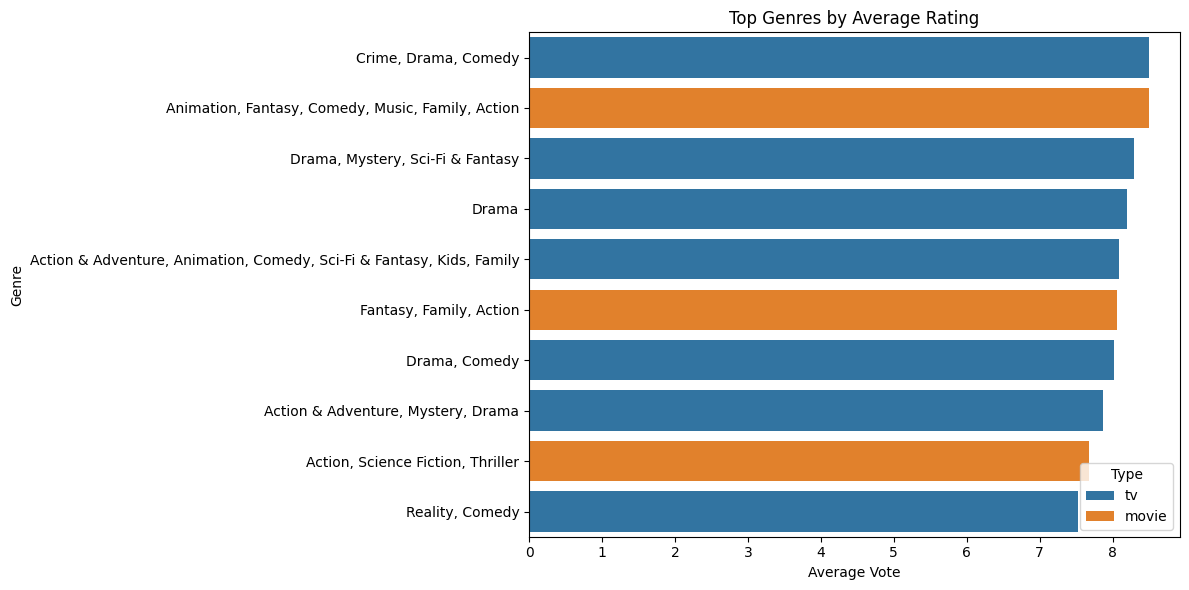

In [74]:
# Plot top genres
plt.figure(figsize=(12, 6))
top_genres = joined_data.sort_values("avg_rating", ascending=False).head(10)
sns.barplot(data=top_genres, x="avg_rating", y="genre_names", hue="type")
plt.title("Top Genres by Average Rating")
plt.xlabel("Average Vote")
plt.ylabel("Genre")
plt.legend(title="Type")
plt.tight_layout()
plt.show()


In [75]:
# Example TMDb call
url = f"https://api.themoviedb.org/3/movie/popular?api_key={api_key}&language=en-US&page=1"
response = requests.get(url)

# Convert to DataFrame
if response.status_code == 200:
    data = response.json()["results"]
    df = pd.json_normalize(data)
    
    # Print all column names
    print("All columns in the DataFrame:")
    print(df.columns.tolist())
else:
    print("API call failed:", response.status_code)

All columns in the DataFrame:
['adult', 'backdrop_path', 'genre_ids', 'id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'release_date', 'title', 'video', 'vote_average', 'vote_count']


In [76]:
# Function to fetch genre mapping from TMDb API
def get_genre_map(api_key, content_type="movie"):
    url = f"https://api.themoviedb.org/3/genre/{content_type}/list?api_key={api_key}&language=en-US"
    response = requests.get(url)
    if response.status_code == 200:
        genres = response.json()['genres']
        return {genre['id']: genre['name'] for genre in genres}
    else:
        print(f"Failed to fetch {content_type} genres")
        return {}

In [77]:
# Helper to map genre IDs to names
def map_genres(genre_ids, genre_map):
    return [genre_map.get(genre_id, "Unknown") for genre_id in genre_ids]

In [78]:
# Fetch genre maps
movie_genres = get_genre_map(api_key, "movie")
tv_genres = get_genre_map(api_key, "tv")


In [79]:
# Fetch movie and TV show data
def tmdb_data(api_key, content_type):
    url = f"https://api.themoviedb.org/3/{content_type}/popular"
    params = {"api_key": api_key, "language": "en-US", "page": 1}
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()['results']
        df = pd.json_normalize(data)
        df['type'] = content_type

        # Dynamically assign title column
        if content_type == "movie":
            df['title'] = df.get('title', 'Unknown')
        else:
            df['title'] = df.get('name', 'Unknown')

        genre_map = movie_genres if content_type == "movie" else tv_genres
        df['genre_names'] = df['genre_ids'].apply(lambda ids: map_genres(ids, genre_map))
        return df
    else:
        print(f"Failed to fetch {content_type} data: {response.status_code}")
        return pd.DataFrame()

# Load movie and TV data
movie_df = tmdb_data(api_key, "movie")
tv_df = fetch_tmdb_data(api_key, "tv")

# Combine both datasets
combined_df = pd.concat([movie_df, tv_df], ignore_index=True)

TypeError: fetch_tmdb_data() takes 1 positional argument but 2 were given

In [ ]:
def data_overview(df: pd.DataFrame, name: str) -> None:
    print(f"\n{name}")
    print("Shape:", df.shape)
    print("\nColumn Types:")
    print(df.dtypes)
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nFirst 5 Rows:")
    print(df.head())
    print("\nSummary Statistics:")
    print(df.describe(include='all'))

# Show EDA for movies and TV
data_overview(movie_df, "TMDb Movie Data")
data_overview(tv_df, "TMDb TV Show Data")


TMDb Movie Data
Shape: (20, 16)

Column Types:
adult                   bool
backdrop_path         object
genre_ids             object
id                     int64
original_language     object
original_title        object
overview              object
popularity           float64
poster_path           object
release_date          object
title                 object
video                   bool
vote_average         float64
vote_count             int64
type                  object
genre_names           object
dtype: object

Missing Values:
adult                0
backdrop_path        0
genre_ids            0
id                   0
original_language    0
original_title       0
overview             0
popularity           0
poster_path          0
release_date         0
title                0
video                0
vote_average         0
vote_count           0
type                 0
genre_names          0
dtype: int64

First 5 Rows:
   adult                     backdrop_path             genre_

In [ ]:
def clean_tmdb_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Keep relevant columns only
    df = df[['title', 'vote_average', 'genre_names', 'popularity', 'type']]
    df = df.dropna(subset=['title', 'vote_average'])
    df['genre_names'] = df['genre_names'].apply(lambda x: ', '.join(x) if isinstance(x, list) else "Unknown")
    return df.reset_index(drop=True)

# Clean the combined data
tmdb_clean = clean_tmdb_df(combined_df)
data_overview(tmdb_clean, "Cleaned TMDb Combined Data")


Cleaned TMDb Combined Data
Shape: (40, 5)

Column Types:
title            object
vote_average    float64
genre_names      object
popularity      float64
type             object
dtype: object

Missing Values:
title           0
vote_average    0
genre_names     0
popularity      0
type            0
dtype: int64

First 5 Rows:
                                            title  vote_average  \
0                               War of the Worlds         4.561   
1                        How to Train Your Dragon         8.068   
2  Demon Slayer: Kimetsu no Yaiba Infinity Castle         6.948   
3                                   Lilo & Stitch         7.337   
4                                 Happy Gilmore 2         6.780   

                                  genre_names  popularity   type  
0                   Science Fiction, Thriller    701.6547  movie  
1                     Fantasy, Family, Action    663.8759  movie  
2        Animation, Action, Fantasy, Thriller    600.6803  movie  
3 

In [ ]:
# Save to SQLite
conn = sqlite3.connect("tmdb_data.db")
tmdb_clean.to_sql("tmdb_titles", conn, if_exists="replace", index=False)

# Example aggregation query
query = """
SELECT genre_names, type, COUNT(*) AS title_count, AVG(vote_average) AS avg_rating
FROM tmdb_titles
GROUP BY genre_names, type
ORDER BY avg_rating DESC
"""

joined_data = pd.read_sql_query(query, conn)
conn.close()

# Preview joined insights
print(joined_data.head())

                                         genre_names   type  title_count  \
0                               Crime, Drama, Comedy     tv            1   
1  Animation, Fantasy, Comedy, Music, Family, Action  movie            1   
2                   Drama, Mystery, Sci-Fi & Fantasy     tv            1   
3                                              Drama     tv            1   
4  Action & Adventure, Animation, Comedy, Sci-Fi ...     tv            1   

   avg_rating  
0       8.500  
1       8.495  
2       8.299  
3       8.200  
4       8.088  


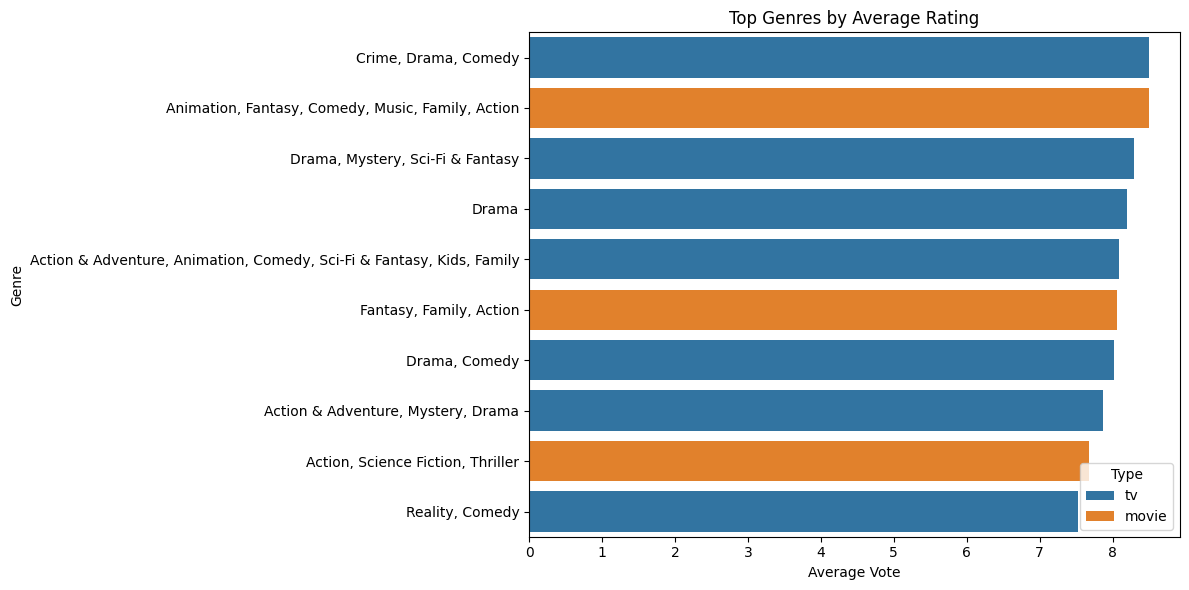

In [ ]:
# Bar plot of top genres by average rating
plt.figure(figsize=(12, 6))
sns.barplot(data=joined_data.sort_values('avg_rating', ascending=False).head(10),
            x='avg_rating', y='genre_names', hue='type')
plt.title("Top Genres by Average Rating")
plt.xlabel("Average Vote")
plt.ylabel("Genre")
plt.legend(title="Type")
plt.tight_layout()
plt.show()

C:\Users\mtsim\AppData\Local\Temp\ipykernel_27920\2604221987.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='cubehelix')


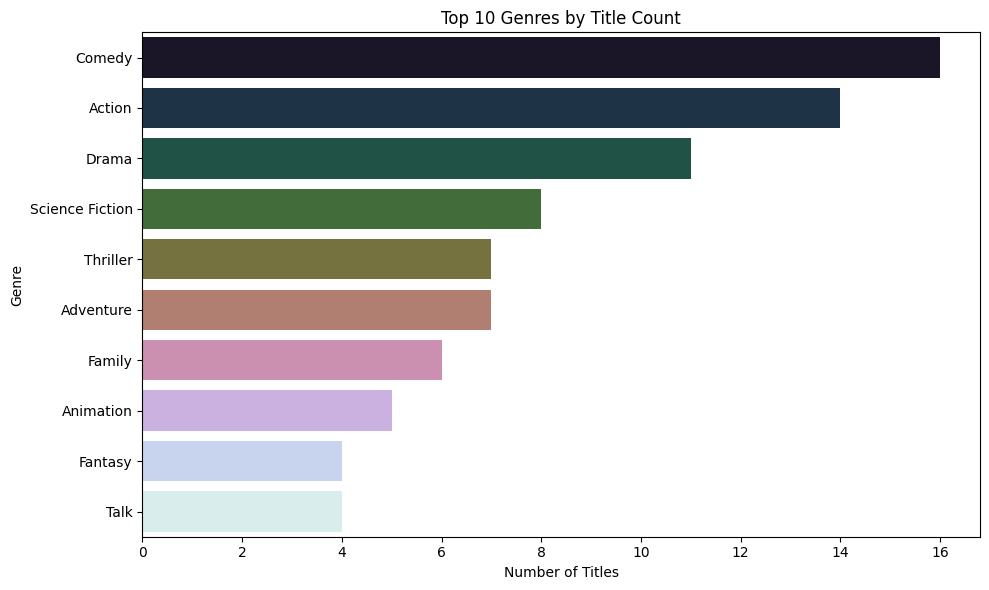

In [ ]:
genre_counts = combined_df.explode('genre_names')['genre_names'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='cubehelix')
plt.title("Top 10 Genres by Title Count")
plt.xlabel("Number of Titles")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

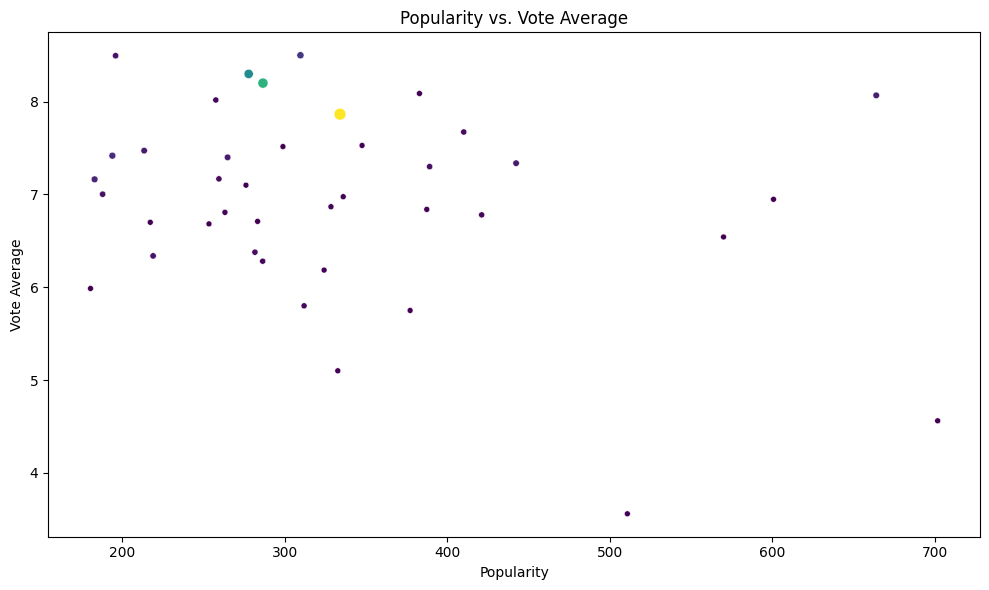

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_df, x='popularity', y='vote_average', hue='vote_count', size='vote_count', palette='viridis', legend=False)
plt.title("Popularity vs. Vote Average")
plt.xlabel("Popularity")
plt.ylabel("Vote Average")
plt.tight_layout()
plt.show()